Buffer de 50m guardado en: /Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_50mts.shp
Buffer de 100m guardado en: /Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_100mts.shp
Buffer de 150m guardado en: /Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_150mts.shp
Buffer de 300m guardado en: /Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_300mts.shp
Buffer de 500m guardado en: /Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_500mts.shp
Buffers creados exitosamente.


<Figure size 1000x1000 with 0 Axes>

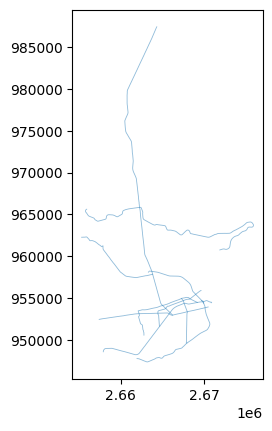

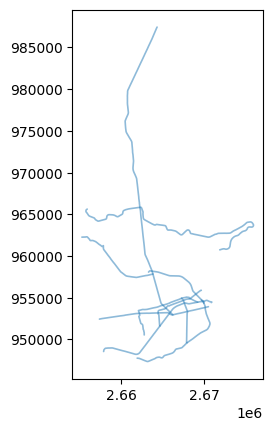

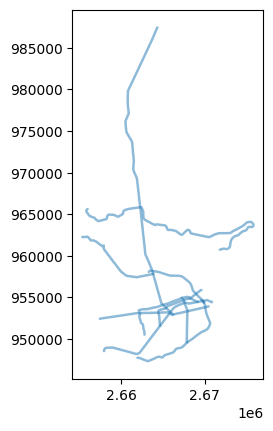

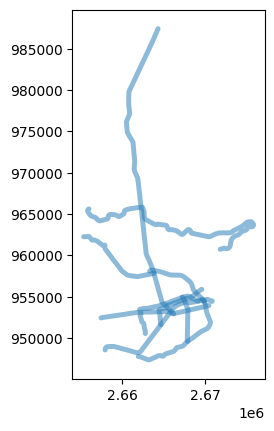

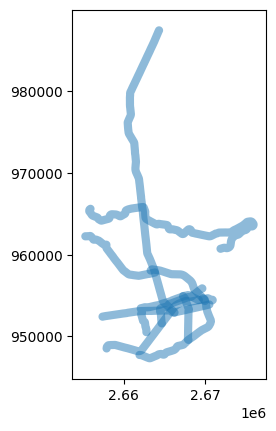

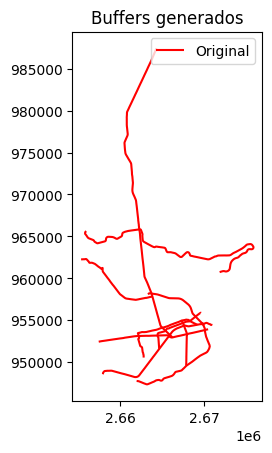

In [1]:
# QUERÉTARO

# ESTE ES QUE HACE LOS BUFFERS

import geopandas as gpd
import pandas as pd
import os

# 1. Cargar tu capa desde archivo (reemplaza con la ruta de tu archivo)
ruta_capa = "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Calles/10_Calles.shp"  
# Cambia esta ruta
capa = gpd.read_file(ruta_capa)

# 3. Crear buffers para las distancias deseadas
distancias = [50, 100, 150, 300, 500]  # Distancias en metros

# Carpeta de salida para guardar los buffers
carpeta_salida = "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers"
os.makedirs(carpeta_salida, exist_ok=True)

# Crear y guardar buffers
buffers = {}  # Diccionario para almacenar las capas de buffers
for distancia in distancias:
    buffer = capa.copy()
    buffer["geometry"] = buffer["geometry"].buffer(distancia)
    buffers[distancia] = buffer
    
    # Guardar el buffer en un archivo
    ruta_buffer = os.path.join(carpeta_salida, f"buffer_{distancia}mts.shp")
    buffer.to_file(ruta_buffer)
    print(f"Buffer de {distancia}m guardado en: {ruta_buffer}")

print("Buffers creados exitosamente.")

# 4. Visualizar los buffers (opcional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for distancia, buffer in buffers.items():
    buffer.plot(alpha=0.5, label=f"{distancia}m")
capa.plot(color="red", markersize=5, label="Original")  # Capa original en rojo
plt.title("Buffers generados")
plt.legend()
plt.show()

In [3]:
# ESTE ES EL BUENO PARA LOS RESULTADOS DE HOSPITALES

import geopandas as gpd
import pandas as pd
import os

# 1. Lista de rutas a las capas de buffers (sin disolver)
rutas_buffers = [
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_50mts.shp",
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_100mts.shp",
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_150mts.shp",
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_300mts.shp",
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_500mts.shp",
]

# 2. Cargar la capa de puntos (hospitales)
ruta_hospitales = "/Users/eileenyuen/SIG/ObservatorioCiudades/AGS/HOSPITALES_save.geojson"
capa_hospitales = gpd.read_file(ruta_hospitales)

# Verificar CRS de la capa de hospitales
if capa_hospitales.crs is None:
    raise ValueError("La capa de hospitales no tiene CRS definido.")

# 3. Iterar sobre cada buffer
for ruta_buffer in rutas_buffers:
    # Cargar el buffer actual
    buffer = gpd.read_file(ruta_buffer)
    
    # Asegurarse de que CRS coincidan
    if buffer.crs != capa_hospitales.crs:
        capa_hospitales = capa_hospitales.to_crs(buffer.crs)
    
    # Realizar el clip (recortar puntos dentro del buffer)
    puntos_clipeados = gpd.clip(capa_hospitales, buffer)
    
    # Unión espacial para asignar puntos a cada buffer
    union_espacial = gpd.sjoin(puntos_clipeados, buffer, how="inner", predicate="intersects")

    # Resumir por calle (ajustando el campo "Nombre_Cal" según el nombre correcto)
    resumen = union_espacial.groupby("Nombre")["total_de_camas"].sum().reset_index()
    resumen = resumen.rename(columns={"total_de_camas": "suma_total_camas"})
    
    # Agregar una columna indicando el buffer procesado (e.g., "50mts")
    buffer_distancia = ruta_buffer.split("/")[-1].split(".")[0]  # Extraer nombre del archivo
    resumen["buffer_distancia"] = buffer_distancia
    
    # Contar el número de puntos (hospitales) dentro de cada buffer
    conteo_puntos = union_espacial.groupby("Nombre").size().reset_index(name="numero_de_hospitales")
    
    # Unir el resumen con el conteo de hospitales
    resumen_completo = pd.merge(resumen, conteo_puntos, on="Nombre", how="left")
    
    # Mostrar la tabla individual
    print(f"Tabla de resumen para el buffer: {buffer_distancia}")
    print(resumen_completo)
    print("\n" + "="*40 + "\n")

Tabla de resumen para el buffer: buffer_50mts
         Nombre  suma_total_camas buffer_distancia  numero_de_hospitales
0  5 de Febrero               212     buffer_50mts                     1


Tabla de resumen para el buffer: buffer_100mts
                Nombre  suma_total_camas buffer_distancia  \
0         5 de Febrero               499    buffer_100mts   
1  Fray Junipero Serra               260    buffer_100mts   
2             Zaragoza               220    buffer_100mts   

   numero_de_hospitales  
0                     2  
1                     1  
2                     1  


Tabla de resumen para el buffer: buffer_150mts
                Nombre  suma_total_camas buffer_distancia  \
0         5 de Febrero               499    buffer_150mts   
1  Fray Junipero Serra               260    buffer_150mts   
2             Zaragoza               220    buffer_150mts   

   numero_de_hospitales  
0                     2  
1                     1  
2                     1  


Tabla de r

In [4]:
# ESTE ES EL BUENO PARA LOS RESULTADOS DE ESCUELAS

import geopandas as gpd
import pandas as pd
import os

# 1. Lista de rutas a las capas de buffers (sin disolver)
rutas_buffers = [
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_50mts.shp",
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_100mts.shp",
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_150mts.shp",
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_300mts.shp",
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_500mts.shp",
]

# 2. Cargar la capa de puntos (escuelas)
ruta_escuelas = "/Users/eileenyuen/SIG/ObservatorioCiudades/IRA/02_ESCUELAS/Escuelas.shp"  
capa_escuelas = gpd.read_file(ruta_escuelas)

# Verificar CRS de la capa de escuelas
if capa_escuelas.crs is None:
    raise ValueError("La capa de escuelas no tiene CRS definido.")

# Imprimir las columnas de la capa de escuelas para verificar los nombres
print("Columnas de la capa de escuelas:")
print(capa_escuelas.columns)

# 3. Iterar sobre cada buffer
for ruta_buffer in rutas_buffers:
    # Cargar el buffer actual
    buffer = gpd.read_file(ruta_buffer)
    
    # Asegurarse de que CRS coincidan
    if buffer.crs != capa_escuelas.crs:
        capa_escuelas = capa_escuelas.to_crs(buffer.crs)
    
    # Realizar el clip (recortar puntos dentro del buffer)
    puntos_clipeados = gpd.clip(capa_escuelas, buffer)
    
    # Unión espacial para asignar puntos a cada buffer
    union_espacial = gpd.sjoin(puntos_clipeados, buffer, how="inner", predicate="intersects")

    # Resumir por calle (ajustando el campo "Nombre_Cal" según el nombre correcto)
    # Cambia "alumnos_total" y "docentes_total" por los nombres correctos si es necesario
    resumen = union_espacial.groupby("Nombre")[["alumnos_to", "docentes_t"]].sum().reset_index()
    
    # Agregar una columna indicando el buffer procesado (e.g., "50mts")
    buffer_distancia = ruta_buffer.split("/")[-1].split(".")[0]  # Extraer nombre del archivo
    resumen["buffer_distancia"] = buffer_distancia
    
    # Mostrar la tabla individual
    print(f"Tabla de resumen para el buffer: {buffer_distancia}")
    print(resumen)
    print("\n" + "="*40 + "\n")

Columnas de la capa de escuelas:
Index(['clave_del_', 'unnamed__0', 'clave_de_1', 'nombre_del', 'nombre_d_1',
       'tipo_educa', 'nivel_educ', 'servicio_e', 'nombre_d_2', 'tipo_de_so',
       'clave_de_l', 'nombre_de_', 'clave_de_2', 'nombre_d_3', 'clave_de_3',
       'nombre_d_4', 'domicilio', 'número_ex', 'entre_la_c', 'y_la_calle',
       'calle_post', 'colonia', 'nombre_d_5', 'código_po', 'clave_lada',
       'teléfono', 'extensión', 'página_we', 'alumnos_to', 'alumnos__1',
       'alumnos__2', 'docentes_t', 'docentes_1', 'docentes_2', 'aulas_en_u',
       'aulas_exis', 'tipo_de_lo', 'x', 'y', 'CVEGEOMUN', 'address', 'latitud',
       'longitud', 'metropolis', 'geometry'],
      dtype='object')
Tabla de resumen para el buffer: buffer_50mts
                     Nombre  alumnos_to  docentes_t buffer_distancia
0              5 de Febrero       548.0         2.0     buffer_50mts
1               Av. Del Sol       466.0         0.0     buffer_50mts
2         Bernardo Quintana       333

In [9]:
# ESTE ES EL BUENO PARA LOS RESULTADOS DENUE

import geopandas as gpd
import pandas as pd
import os

# 1. Lista de rutas a las capas de buffers (sin disolver)
rutas_buffers = [
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_50mts.shp",
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_100mts.shp",
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_150mts.shp",
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_300mts.shp",
    "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/04 Buffers/buffer_500mts.shp",
]

# 2. Cargar la capa de puntos (DENUE)
ruta_denue = "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/denue_2020.shp"
capa_denue = gpd.read_file(ruta_denue)

# Verificar CRS de la capa de hospitales
if capa_denue.crs is None:
    raise ValueError("La capa de denue no tiene CRS definido.")

# 3. Iterar sobre cada buffer
for ruta_buffer in rutas_buffers:
    # Cargar el buffer actual
    buffer = gpd.read_file(ruta_buffer)
    
    # Asegurarse de que CRS coincidan
    if buffer.crs != capa_denue.crs:
        capa_denue = capa_denue.to_crs(buffer.crs)
    
    # Realizar el clip (recortar puntos dentro del buffer)
    puntos_clipeados = gpd.clip(capa_denue, buffer)
    
    # Unión espacial para asignar puntos a cada buffer
    union_espacial = gpd.sjoin(puntos_clipeados, buffer, how="inner", predicate="intersects")

    # Resumir por calle (ajustando el campo "Nombre_Cal" según el nombre correcto)
    resumen = union_espacial.groupby("Nombre")["num_trabaj"].sum().reset_index()
    resumen = resumen.rename(columns={"num_trabaj": "suma_tot_trabajadores"})
    
    # Agregar una columna indicando el buffer procesado (e.g., "50mts")
    buffer_distancia = ruta_buffer.split("/")[-1].split(".")[0]  # Extraer nombre del archivo
    resumen["buffer_distancia"] = buffer_distancia
    
    # Contar el número de puntos (denue) dentro de cada buffer
    conteo_puntos = union_espacial.groupby("Nombre").size().reset_index(name="numero_denue")
    
    # Unir el resumen con el conteo de denue
    resumen_completo = pd.merge(resumen, conteo_puntos, on="Nombre", how="left")
    
    # Mostrar la tabla individual
    print(f"Tabla de resumen para el buffer: {buffer_distancia}")
    print(resumen_completo)
    print("\n" + "="*40 + "\n")

Tabla de resumen para el buffer: buffer_50mts
                       Nombre  suma_tot_trabajadores buffer_distancia  \
0                5 de Febrero                  24046     buffer_50mts   
1  Autopista Mexico-Queretaro                   2918     buffer_50mts   
2                 Av. Del Sol                   4083     buffer_50mts   
3           Bernardo Quintana                  12476     buffer_50mts   
4              Constituyentes                  21411     buffer_50mts   
5         Fray Junipero Serra                    731     buffer_50mts   
6    Libramiento Sur Poniente                   3855     buffer_50mts   
7                     Pasteur                   4981     buffer_50mts   
8                 Pino Suarez                   7982     buffer_50mts   
9                    Zaragoza                  13402     buffer_50mts   

   numero_denue  
0          1092  
1           187  
2           432  
3           783  
4          1371  
5            54  
6           214  
7     

In [7]:
import geopandas as gpd

# Cargar la capa
ruta_capa = "/Users/eileenyuen/SIG/ObservatorioCiudades/QRO/denue_2020.shp"  # Cambia por la ruta a tu archivo
capa = gpd.read_file(ruta_capa)

# Mostrar los campos (columnas)
print("Campos disponibles en la capa:")
print(capa.columns)


Campos disponibles en la capa:
Index(['id', 'nom_estab', 'raz_social', 'codigo_act', 'nombre_act', 'per_ocu',
       'tipo_vial', 'nom_vial', 'tipo_v_e_1', 'nom_v_e_1', 'tipo_v_e_2',
       'nom_v_e_2', 'tipo_v_e_3', 'nom_v_e_3', 'numero_ext', 'letra_ext',
       'edificio', 'edificio_e', 'numero_int', 'letra_int', 'tipo_asent',
       'nomb_asent', 'tipo_cenco', 'nom_cencom', 'num_local', 'cod_postal',
       'cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc', 'localidad',
       'ageb', 'manzana', 'telefono', 'correoelec', 'www', 'tipo_uni_e',
       'latitud', 'longitud', 'fecha_alta', 'num_trabaj', 'geometry'],
      dtype='object')
